In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import nilearn.plotting as nip
import seaborn as sns
from matplotlib.colors import ListedColormap
from nibabel.affines import apply_affine
import numpy.linalg as npl
from nilearn.reporting import get_clusters_table
from scipy.ndimage import distance_transform_edt

from nilearn.datasets import fetch_atlas_difumo
difumo_data = fetch_atlas_difumo(dimension=128, resolution_mm=2, data_dir=None, resume=True, verbose=1, legacy_format=False)
# load 4d image and fetch the first volume
difumo_4d = nib.load(difumo_data['maps'])

def get_difumo_label(world_coord):
    voxel_coord = apply_affine(npl.inv(difumo_4d.affine), world_coord).astype(int)
    max = np.max(difumo_4d.get_fdata()[voxel_coord[0], voxel_coord[1], voxel_coord[2], :])
    argmax = np.argmax(difumo_4d.get_fdata()[voxel_coord[0], voxel_coord[1], voxel_coord[2], :])
    location = difumo_data['labels'].iloc[argmax, :]
    return location['difumo_names'], location['yeo_networks7'], max


mars_labelmap = nib.load('../resources/MNI152_nonlin_MarsAtlas.nii.gz')
mars_labels = pd.read_csv('../resources/MarsLabels_long.csv', index_col=False)

def get_mars_label(world_coord, max_radius=30):
    voxel_coord = apply_affine(npl.inv(mars_labelmap.affine), world_coord).astype(int)
    labelmap_data = mars_labelmap.get_fdata()
    nonzero_mask = labelmap_data > 0
    # Compute distance transform
    distances, indices = distance_transform_edt(~nonzero_mask, return_indices=True)
    # Get the closest non-zero label within the max_radius
    closest_voxel_coord = indices[:, voxel_coord[0], voxel_coord[1], voxel_coord[2]]
    # Ensure the closest voxel is within max_radius
    distance_to_closest = distances[tuple(voxel_coord)]
    if distance_to_closest > max_radius:
        return 0  # Return 0 if no non-zero label is within the radius
    label = labelmap_data[closest_voxel_coord[0], closest_voxel_coord[1], closest_voxel_coord[2]]
    res = mars_labels.loc[mars_labels['Index'] == label, :].copy()
    res.loc[:, 'Distance'] = distance_to_closest
    return res
   

dir_mediation = '/Users/tspisak/data/PIC_conditioning_withinsub_nodatalad/mediation_signflipped_signedquantile_results'
data4d_harmonized = nib.load(f'{dir_mediation}/../all_data_studyranked.nii')
pheno = pd.read_csv(f'{dir_mediation}/../signatures.csv')
# get mean effect in each group for a given voxel
def get_stats(voxel_coord, stat_fun, data4d=data4d_harmonized, pheno=pheno):
    data = data4d.get_fdata()[voxel_coord[0], voxel_coord[1], voxel_coord[2], :]
    return stat_fun(data, pheno)

def stat_fun_groupmeans(data, pheno):
    return np.mean(data[pheno['Conditioning']=='suggestions']), np.mean(data[pheno['Conditioning']=='suggestions & conditioning'])

def stat_fun_percgt0(data, pheno):
    mean_INT, mean_CONDINT = stat_fun_groupmeans(data, pheno)
    return (mean_INT+0.5)*100, (mean_CONDINT+0.5)*100 #weighted average (across studies) of the % of participants with a positive effect

my_cmp = ListedColormap(['cyan', 'blue', 'white', 'white', 'red', 'orange'])

/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
mask = nib.load(f'{dir_mediation}/../full_masked_10_percent.nii')
mask_data = mask.get_fdata()

contrast = [
    "PathA(XM)",
    "PathB(MY)",
    "Indirect(ACME)",
    "Direct(Total-Indirect)",
    "INST_mean",
    "CONDINST_mean",
    "INSTandCONDINST",
    ]
img_type = ['beta', 'thres', 'uncorr_logp', 'fdr_logq']

img = {}
for c in contrast:
    img[c] = {}
    for t in img_type:
        img[c][t] = nib.load(f'{dir_mediation}/{t}_{c}.nii.gz')

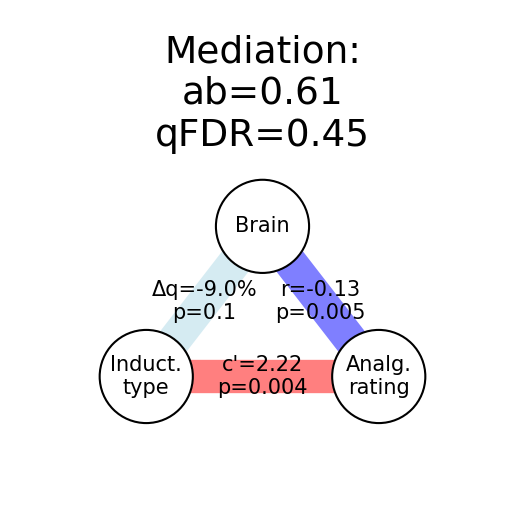

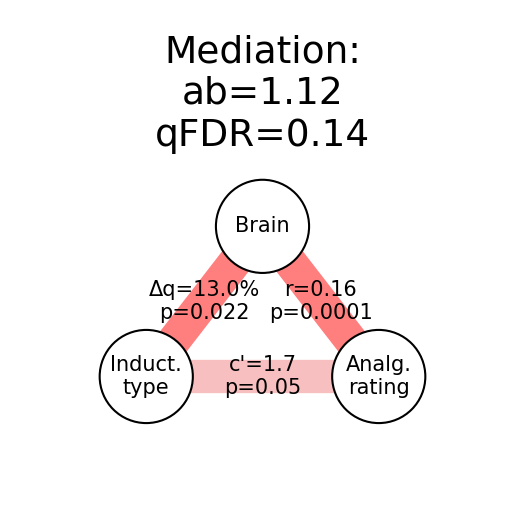

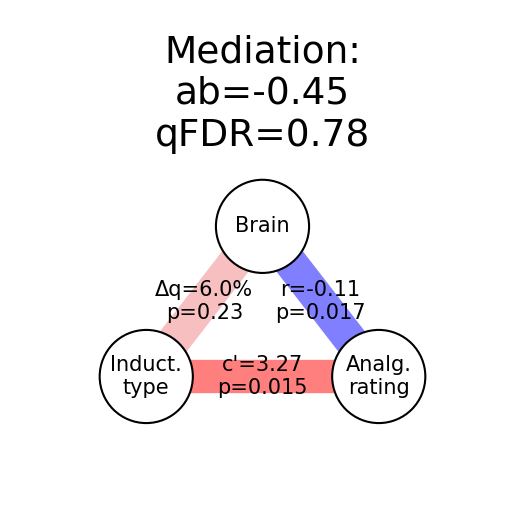

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import to_rgba
plt.style.use('default')

def edgecolor(beta, p):
    if beta>0:
        if p<0.05:
            return 'red'
        else:
            return 'lightcoral'
    else:
        if p<0.05:
            return 'blue'
        else:
            return 'lightblue'
        
def convert_p(p):
    if p>0.05:
        return f'={np.round(p, 2)}'
    elif p>0.001:
        return f'={np.round(p, 3)}'
    elif p>0.0001:
        return f'={np.round(p, 4)}'
    else:
        return '<0.0001'

def pathdiagram(x, y, z):
    x, y, z = apply_affine(npl.inv(img['PathB(MY)']['beta'].affine), (x, y, z)).astype(int)
    
    pathA_beta = img['PathA(XM)']['beta'].get_fdata()[x, y, z]
    pathA_p = 10**-img['PathA(XM)']['uncorr_logp'].get_fdata()[x, y, z] 
    pathA_fdrq = 10**-img['PathA(XM)']['fdr_logq'].get_fdata()[x, y, z] 
    
    pathB_beta = img['PathB(MY)']['beta'].get_fdata()[x, y, z]
    pathB_p = 10**-img['PathB(MY)']['uncorr_logp'].get_fdata()[x, y, z] 
    pathB_fdrq = 10**-img['PathB(MY)']['fdr_logq'].get_fdata()[x, y, z] 
    
    pathCprime_beta = img['Direct(Total-Indirect)']['beta'].get_fdata()[x, y, z] 
    pathCprime_p = 10**-img['Direct(Total-Indirect)']['uncorr_logp'].get_fdata()[x, y, z] 
    pathCprime_fdrq = 10**-img['Direct(Total-Indirect)']['fdr_logq'].get_fdata()[x, y, z] 
      
    pathMediation_beta = img['Indirect(ACME)']['beta'].get_fdata()[x, y, z]
    pathMediation_fdrq = 10**-img['Indirect(ACME)']['fdr_logq'].get_fdata()[x, y, z] 
    
    
    
    # Create a directed graph
    G = nx.DiGraph()
    # Define nodes for the mediation model
    
    X='Induct.\ntype'
    M='Brain'
    Y='Analg.\nrating'
    
    nodes = [X, M, Y]
    G.add_nodes_from(nodes)

    # Define edges for the mediation model
    edges = [(X, M), (M, Y), (X, Y)]
    G.add_edges_from(edges)

    # Define the layout for the nodes
    pos = {
        X: (0, 0),
        M: (1, 1.3),
        Y: (2, 0)
    }
    # Draw the nodes
    plt.figure(1, figsize=(2, 2), dpi=300)
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color=['white', 'white', 'white'], edgecolors='black', linewidths=0.5)
    # Draw the edges
    nx.draw_networkx_edges(G, pos, edgelist=[(X, M)], arrowstyle='-', arrowsize=20,
                           edge_color=edgecolor(pathA_beta, pathA_p), width=8, alpha=0.5)
    nx.draw_networkx_edges(G, pos, edgelist=[(M, Y)], arrowstyle='-', arrowsize=20,
                           edge_color=edgecolor(pathB_beta, pathB_p), width=8, alpha=0.5)
    nx.draw_networkx_edges(G, pos, edgelist=[(X, Y)], arrowstyle='-', arrowsize=20,
                           edge_color=edgecolor(pathCprime_beta, pathCprime_p), width=8, alpha=0.5)
    # Draw the labels
    nx.draw_networkx_labels(G, pos, labels={X: X, M: M, Y: Y}, font_size=5, font_color='black')
    
    # edge labels
    pathA_beta = np.round(pathA_beta, 2)*100
    pathA_p = convert_p(pathA_p)
    pathA_fdrq = convert_p(pathA_fdrq)
    pathB_beta = np.round(pathB_beta*(1/(2*np.sqrt(3)))/pheno['Rating_diff'].std(), 2) # to correlation
    pathB_p = convert_p(pathB_p)
    pathB_fdrq = convert_p(pathB_fdrq)
    pathCprime_beta = np.round(pathCprime_beta, 2)
    pathCprime_p = convert_p(pathCprime_p)
    pathCprime_fdrq = convert_p(pathCprime_fdrq)
        
    nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={(X, M): f'Δq={pathA_beta}%\np{pathA_p}', #\nq{pathA_fdrq}
                 (M, Y): f'r={pathB_beta}\np{pathB_p}',  #\nq{pathB_fdrq}
                 (X, Y): f"c'={pathCprime_beta}\np{pathCprime_p}"}, #\nq{pathCprime_fdrq}
        font_color='black',
        rotate=False,
        font_size=5,
        label_pos=0.5,
        bbox = dict(facecolor = "white", alpha=0)
)
    # Display the plot
    plt.axis('off')  # Turn off the axis
    #plt.tight_layout() 
    # maybe smaller factors work as well, but 1.1 works fine for this minimal example
    axis = plt.gca()
    axis.set_xlim([-1,3])
    axis.set_ylim([-1,3])
    
    pathMediation_beta = np.round(pathMediation_beta, 2)
    pathMediation_fdrq = convert_p(pathMediation_fdrq)
    plt.text(1, 2, f'Mediation:\nab={pathMediation_beta}\nqFDR{pathMediation_fdrq}', fontsize=9, horizontalalignment='center')
    
    #plt.show() 

# test it
pathdiagram(36, -16, 18)
plt.show()
pathdiagram(8.0,28.0,-14.0)
plt.show()
pathdiagram(60, 4, 8)


### MricroGL scripts
We select slices with at least n_sign significant voxels

In [4]:
nip.view_img(img['Indirect(ACME)']['thres']).open_in_browser()

/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [5]:
data = np.copy(img['Indirect(ACME)']['thres'].get_fdata())
# positive mediation means "suppression effect":
# - either by increased activity with COND and stronger brain-behavior mediates the COND effect on behavior
# - or by activity decrease with COND and weaker brain-behavior correlation mediates the COND effect on behavior
# focus on negative mediation (there's not much negative, anyway)
data[data>0] = 0
# in these voxels, a and b have the same sign, i.e. the positive X->Y is mediated:
# - either more activity with COND and weaker brain-behavioral correlates mediates the COND effect on behavior
# - or less activity with COND and stronger brain-behavioral correlates mediates the COND effect on behavior
data *= np.sign(img['PathA(XM)']['beta'].get_fdata())
img['Indirect(ACME)']['thres_neg'] = nib.Nifti2Image(data, affine=img['Indirect(ACME)']['thres'].affine)
nib.save(img['Indirect(ACME)']['thres_neg'], f'{dir_mediation}/thres_neg_Indirect(ACME).nii.gz')

In [6]:
nip.view_img(img['Indirect(ACME)']['thres_neg']).open_in_browser()

/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [7]:
from nilearn.plotting import find_cut_slices
data = np.copy(-1*img['Indirect(ACME)']['uncorr_logp'].get_fdata())
data[img['Indirect(ACME)']['uncorr_logp'].get_fdata()<0] = 0 # omit "supression effects"
coords = find_cut_slices(nib.Nifti2Image(data, affine=img['Indirect(ACME)']['thres'].affine), direction="z", n_cuts=9)
coords = ' '.join(str(z) for z in coords)
f'A H -0.1 V -0.1 {coords} S X R 0'

'A H -0.1 V -0.1 -38.0 -20.0 -10.0 0.0 12.0 22.0 40.0 54.0 68.0 S X R 0'

In [8]:
clust_table = get_clusters_table(stat_img=img['Indirect(ACME)']['uncorr_logp'],
                                 stat_threshold=-np.log10(0.01),
                                 cluster_threshold=2,
                                 min_distance=20
                                 )

clust_table['region'] = 'N/A'
clust_table['yeo_network'] = 'N/A'

for i, row in clust_table.iterrows():
    x, y, z = row['X'], row['Y'], row['Z']
    x_vox, y_vox, z_vox = apply_affine(npl.inv(img['Indirect(ACME)']['beta'].affine), (x, y, z)).astype(int)
    clust_table.loc[row.name, 'Effect size'] = img['Indirect(ACME)']['beta'].get_fdata()[x_vox, y_vox, z_vox]
    if clust_table.loc[row.name, 'Effect size'] > 0: # only retain supression effects
        clust_table.drop(row.name, inplace=True)
        continue
    
    clust_table.loc[row.name, 'Path A percentile change'] = img['PathA(XM)']['beta'].get_fdata()[x_vox, y_vox, z_vox]*100
    clust_table.loc[row.name, 'Path B correlation'] = img['CONDINST_mean']['beta'].get_fdata()[x_vox, y_vox, z_vox]*(1/(2*np.sqrt(3)))/pheno['Rating_diff'].std() # beta to correlation
    
    mars_region = get_mars_label([x, y, z])
    clust_table.loc[row.name, 'Mars region'] = mars_region['Hemisphere'].values[0] + ' ' + mars_region['Full_name'].values[0] 

    region, yeo_nw, prob = get_difumo_label([x, y, z])
    clust_table.loc[row.name, 'DiFuMo region'] = region
    clust_table.loc[row.name, 'yeo_network'] = yeo_nw

    clust_table.loc[row.name, 'Peak Stat uncorr'] = 10 ** (-row['Peak Stat'])
    if clust_table.loc[row.name, 'Peak Stat uncorr'] < 0.0001:
        clust_table.loc[row.name, 'Peak Stat uncorr'] = '<0.0001'
    clust_table.loc[row.name, 'Peak Stat FDR'] = 10 ** (- img['Indirect(ACME)']['fdr_logq'].get_fdata()[x_vox, y_vox, z_vox])
    
    # delete row if peak is not fdr significant
    if clust_table.loc[row.name, 'Peak Stat FDR'] > 0.05:
        clust_table.drop(row.name, inplace=True)
        continue
    
    if clust_table.loc[row.name, 'Peak Stat FDR'] < 0.0001:
        clust_table.loc[row.name, 'Peak Stat FDR'] = '<0.0001'
        

    ### specific for path A
    pgt0_INT, pgt0_CONDINT = get_stats(voxel_coord=(x_vox, y_vox, z_vox), stat_fun=stat_fun_percgt0)
    # weighted average (across studies) of the % of participants with a positive effect
    clust_table.loc[row.name, 'perc_gt0_INT'] = pgt0_INT
    clust_table.loc[row.name, 'perc_gt0_CONDINT'] = pgt0_CONDINT
    # difference in % of participants with a positive effect - when modelling sex and age
    clust_table.loc[row.name, 'perc_gt0_diff'] = pgt0_CONDINT - pgt0_INT

clust_table[['Cluster ID', 'Cluster Size (mm3)', 'X', 'Y', 'Z', 'Path A percentile change', 'Path B correlation',
     'Effect size', 'Peak Stat uncorr', 'Peak Stat FDR', 'Mars region', 'DiFuMo region', 'yeo_network', ]]

/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_37055/451987328.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<0.0001' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clust_table.loc[row.name, 'Peak Stat uncorr'] = '<0.0001'
/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_37055/451987328.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<0.0001' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clust_table.loc[row.name, 'Peak Stat FDR'] = '<0.0001'


,Cluster ID,Cluster Size (mm3),X,Y,Z,Path A percentile change,Path B correlation,Effect size,Peak Stat uncorr,Peak Stat FDR,Mars region,DiFuMo region,yeo_network
5,6,648,12.0,14.0,68.0,10.308662,0.003478,-0.862489,<0.0001,<0.0001,Right Dorsomedial Premotor Cortex,Cerebrospinal fluid (between superior part of ...,SalVentAttnA
6,7,160,6.0,-10.0,6.0,12.410820,-0.001609,-0.780701,<0.0001,<0.0001,Right Thalamus,Thalamus,No network found
10,11,16,-50.0,-42.0,56.0,11.643742,0.002103,-0.582188,<0.0001,<0.0001,Left Dorsal Inferior Parietal Cortex,Intraparietal sulcus anterior LH,ContA
16,17,104,32.0,-56.0,64.0,8.228928,-0.001316,-0.650941,<0.0001,0.016055,Right Superior Parietal Cortex,Superior parietal lobule anterior,DorsAttnB
21,22,216,14.0,26.0,40.0,17.932856,-0.000436,-1.153654,<0.0001,0.042446,Right Rostral Medial Prefrontal Cortex,Middle frontal gyrus lateral LH,ContA


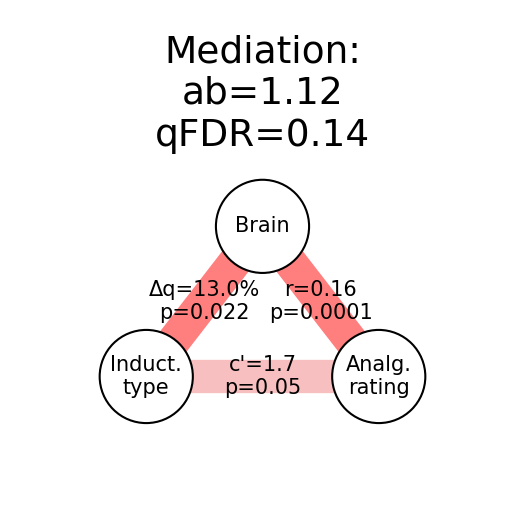

In [9]:
pathdiagram(8.0,28.0,-14.0) # 1,112,8.0,28.0,-14.0,12.123880,0.001975,1.068297,<0.0001,<0.0001,Right Ventromedial Prefrontal Cortex,Middle frontal gyrus lateral LH,ContA


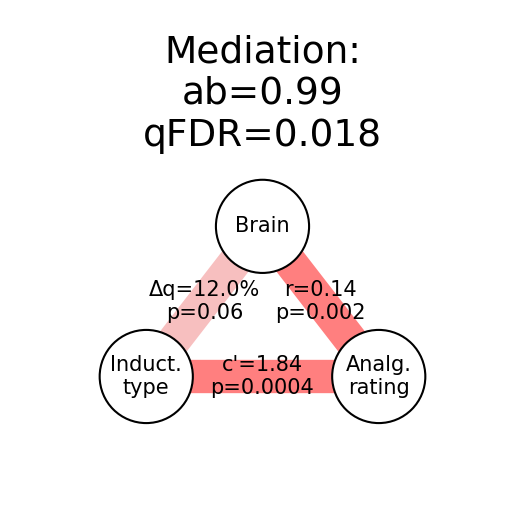

In [10]:
pathdiagram(8.0,2.0,16.0) # 14,40,8.0,2.0,16.0,12.667425,0.000014,1.146064,<0.0001,0.001172,Right Caudate,Caudate,No network found


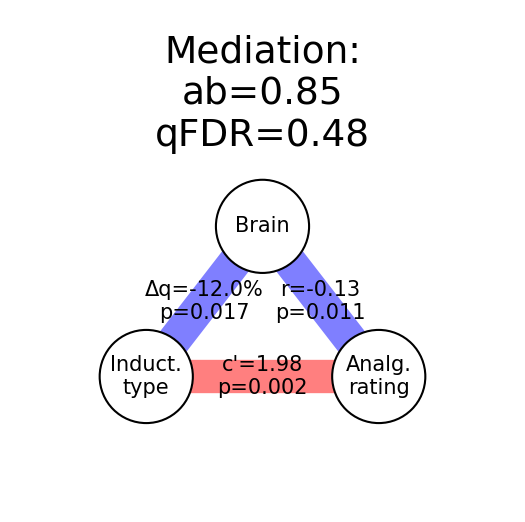

In [11]:
pathdiagram(40.0,-14.0,18.0) # 8,984,40.0,-14.0,18.0,-12.856801,-0.002018,1.088710,<0.0001,<0.0001,Right Ventral Inferior Parietal Cortex,Central operculum cortex,SomMotA
# -> post Insula

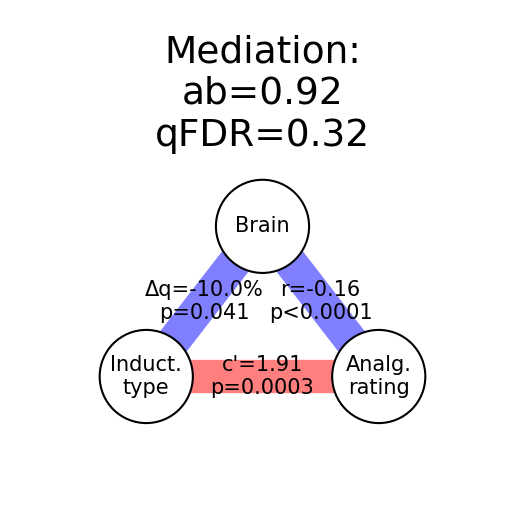

In [12]:
pathdiagram(66.0,-42.0,16.0) # 19,496,66.0,-42.0,16.0,-11.183222,-0.000584,1.151080,<0.0001,0.010921,Right Caudal Superior Temporal Cortex,Angular gyrus RH,DorsAttnB


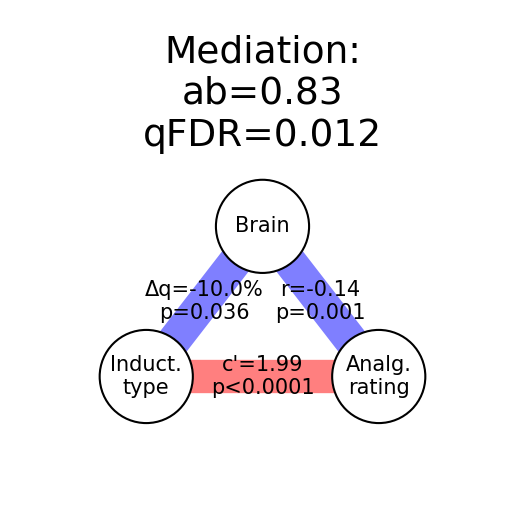

In [13]:
pathdiagram(52.0,-18.0,24.0) # 10,1088,52.0,-18.0,24.0,-10.691226,-0.000019,0.938141,<0.0001,<0.0001,Right Ventral Inferior Parietal Cortex,Supramarginal gyrus anterior RH,SalVentAttnA
# -> S2


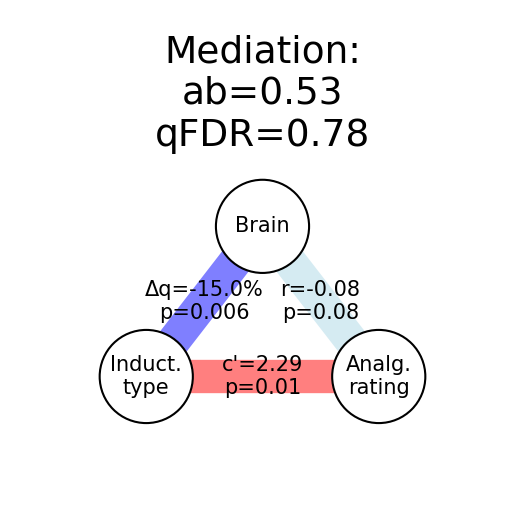

In [14]:
pathdiagram(30.0,-18.0,54.0) # 3,664,30.0,-18.0,54.0,-14.588219,-0.001718,0.954367,<0.0001,<0.0001,Right Dorsomedial Motor Cortex,Middle frontal gyrus lateral LH,ContA


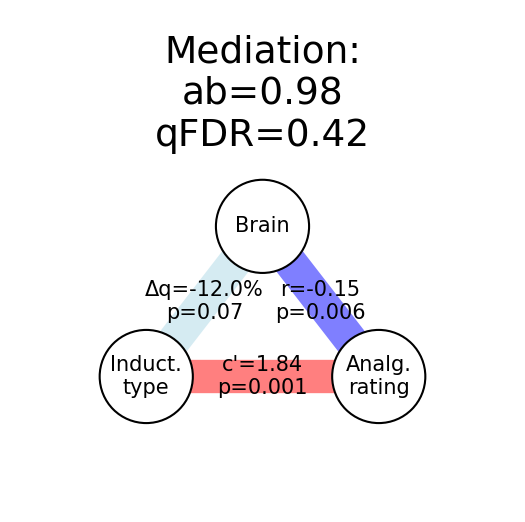

In [15]:
pathdiagram(-14.0,-48.0,68.0) # 13,240,-14.0,-48.0,68.0,-11.778175,-0.001267,1.031782,<0.0001,<0.0001,Left Dorsomedial Somatosensory Cortex,Superior precentral and postcentral sulci posterior,SomMotA
